# Model One: Mappability
Elvira Mingazova, Raffaele Fronza  
May, 2017  
  
First the mappability for the whole genome (hg38) for 3 kmers=[40,100,200] was computed as described in the mappabilityTrack.ipnb file. Wiggle files with variable step were obtained. For the format description see https://genome.ucsc.edu/goldenpath/help/wiggle.html. 

## Task 1: Uniquely mappable regions

For each chromosome compute the length of the uniquely mappable regions (Mc), compute the total mappability (TM). Number of integration regions (n) to be generated on the specific chromosome is n = N*(Mc/TM), where N - total number of IR on the genome. Mc (mappability of the chromosome) is the sum of all positions with mappability = 1 on a specific chromosome, TM (total mappability) is the sum of all positions with mappability = 1 on the total hg38, IR - integration regions.

#### Compute using the .wig files
Chr1 example

In [1]:
#length of the chr1
chr1 = 248956422

In [2]:
import sys

In [3]:
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")

In [4]:
import wiggelen

In [ ]:
#count how many positions have the mappability value equal to 1
counter = 0
for region, position, value in wiggelen.walk(open('../../Desktop/NCT Bioinfo/testData/chr1_40.wig')):
    if value == 1:
        counter+=1
print counter

103547682


This value tells that the mappability of the chr1 is less than 50% which is false. The file <chr1_40.wig> was downloaded incomplete. See the tail-command output below. Last position is 118853022, whether the chr1 length is 248956422. So the uniquely mappable region computed for this incomplete chromosome is 87% until that point.

In [7]:
from __future__ import division
103547682/118853022

0.871224645848719

In [6]:
!tail ../testdata/chr1_40.wig

variableStep	chrom=chr1	span=19
118852984	0.00646306
variableStep	chrom=chr1	span=15
118853003	0.00524922
variableStep	chrom=chr1
118853018	0.00646306
variableStep	chrom=chr1	span=3
118853019	0.00524922
variableStep	chrom=chr1
118853022	0.0

This is the first approach to compute uniquely mappable regions, it takes a lot of time. Another approach was developed using the BEDOPS-tools (https://bedops.readthedocs.io/en/latest/) and awk-commands.

#### Compute using the .bed files
First, the wig files for hg38 and all three kmers were converted to bed format using wig2bed function from the BEDOPS package (http://bedops.readthedocs.io/en/latest/content/reference/file-management/conversion/wig2bed.html). Example code:
```bash
wig2bed < hg38_40.wig > hg38_40.bed
```  
This is how the bed-file looks:

In [7]:
!head ../testdata/chr1_40.wig.bed

chr1	0	10000	id-1	0.000000
chr1	10000	10001	id-2	0.006463
chr1	10001	10005	id-3	0.005249
chr1	10005	10007	id-4	0.006463
chr1	10007	10011	id-5	0.005249
chr1	10011	10013	id-6	0.006463
chr1	10013	10017	id-7	0.005249
chr1	10017	10019	id-8	0.006463
chr1	10019	10023	id-9	0.005249
chr1	10023	10025	id-10	0.006463


Now the idea is to extract a textfile with two columns where the first column is a chromosome name and the second one is the length of uniquely mappable parts. For that it was iterated over a list of chromosome names and bedextract-command from BEDOPS tools was used.

The following bash code was used:
``` bash
declare -a arr=("chr1" "chr2" "chr3" "chr4" "chr5" "chr6" "chr7" "chr8" "chr9" "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18" "chr19" "chr20" "chr21" "chr22" "chrX" "chrY")
#kmer = [40,100,200]
for i in ${arr[@]}; do bedextract "$i" hg38_$kmer.wig.bed | awk -v thr=1 -v chr=$i 'BEGIN {len = 0} {$5>=thr {len = len + ($3-$2)}} END {print chr,len}'; done >> unique_regions_$kmer.txt
```

Chr1 had to be computed separately for kmer40 because ```bedextract chr1``` failed. Why? Bug in the bedextract?
```bash 
awk -v thr=1 -v chr="chr1" 'BEGIN {len=0} $1==chr && $5>=thr {len=len+($3-$2)} END {print chr, len}' hg38_$kmer.wig.bed
```
Another option was to replace chr1 with chr0 using vi in the file hg38_40.bed and then do ```bedextract chr0```:  

```#changes only whole words exactly matching chr1 to chr0 without asking for confirmation```  
:```%s/\<chr1\>/chr0/g```
  
Exit vim and save the file: 
```Esc->:wq->Enter```

All the results were collected into an excel table here https://drive.google.com/open?id=0ByB97k3S0qAFd21jUmtGbVJCNDg

On average about 72% of the human genome is mappable for kmer=40 and around 80% is mappable for kmer=100/200

## Task 2: Generate 3 tables of 100000 IS on map_100, map_40 and map_200

At this point we want to find the way how to extract the integration sites/regions from the mappable parts of hg38 only. For that we will need an appropriate datastructure to generate the positions/regions from. One possible solution is a 2-dimensional numpy array containing regions and information on the mappability. The idea is the following. Starting from a precomputed mappability file in bed-format create a textfile containing two columns: positions on a specific chromosome and True/False statement. If the region is uniquely mappable (mappability = 1) then "True" should be written opposite to it's starting position and if the mappability value is less than 1 - "False".  
this is easily done by using the following command in the terminal:  
```
#kmer = [40,100,200]
bedextract chr1 hg38_$kmer.bed | awk '$5==1 {print $2, "true"} $5<1 {print $2, "false"}' > chr1_$kmer_mappable.txt
```
Here are the first 10 lines of an example file

In [8]:
!head /Users/elming/Advanced-random-IR/testdata/chr1_40_mappable.txt

0 false
10000 false
10001 false
10005 false
10007 false
10011 false
10013 false
10017 false
10019 false
10023 false


From these two columns we can extract the information that chr1 is unmappable (kmer=40) at the positions between 0 and 10023 bp. It is possible to shorten this textfile however without losing any information by deleting the rows containing recurring statements in the 2nd column.  
``` bash
declare -a arr=("chr1" "chr2" "chr3" "chr4" "chr5" "chr6" "chr7" "chr8" "chr9" "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18" "chr19" "chr20" "chr21" "chr22" "chrX" "chrY")
#kmer = [40,100,200]
for i in ${arr[@]}; do bedextract "$i" hg38_$kmer.bed | awk '$5==1 {print $2, "true"} $5<1 {print $2, "false"}' | awk '$2 != prev {print $0} {prev = $2}' > $i_$kmer_mappable.txt; done
```

In [9]:
!head /Users/elming/Advanced-random-IR/testdata/chr1_40_mappableshort.txt

0 false
10314 true
10315 false
10596 true
10611 false
15882 true
15903 false
17454 true
17489 false
30855 true


Now the textfile contains the information that is ready to be passed into a numpy array and 100000 positions can be generated on the mappable regions of each chromosome.

In [5]:
#chromosome sizes
dimension_dict={'chr13': 114364328, 'chr12': 133275309, 'chr11': 135086622, 'chr10': 133797422, 'chr17': 83257441, 'chr16': 90338345, 'chr15': 101991189, 'chr14': 107043718, 'chr19': 58617616, 'chr18': 80373285, 'chr24': 57227415, 'chr22': 50818468, 'chr23': 156040895, 'chr20': 64444167, 'chr21': 46709983, 'chr7': 159345973, 'chr6': 170805979, 'chr5': 181538259, 'chr4': 190214555, 'chr3': 198295559, 'chr2': 242193529, 'chr1': 248956422, 'chr9': 138394717, 'chr8': 145138636}
#percentage of integration sites to be generated on each chromosome according to their relative lengths for three different kmers; 
#info obtained from the excel table from Task 1. Value for chrY was edited according to the other values so that the sum of all values equals to 1
##counter=0
##for key in kmer40.keys():
    ##if key != "chrY":
        ##counter+=kmer200[key]
##print 1-counter
kmer40={'chr1':0.0788750,'chr2':0.086109,'chr3':0.071728,'chr4':0.068060,'chr5':0.063896,'chr6':0.059406,'chr7':0.053514,'chr8':0.051220,'chr9':0.039697,'chr10':0.046955,'chr11':0.046680,'chr12':0.046712,'chr13':0.035519,'chr14':0.030916,'chr15':0.026443,'chr16':0.025715,'chr17':0.024516,'chr18':0.027496,'chr19':0.017131,'chr20':0.022020,'chr21':0.011919,'chr22':0.011228,'chrX':0.050153,'chrY':0.004092}
kmer100={'chr1':0.079149,'chr2':0.085056,'chr3':0.071048,'chr4':0.067183,'chr5':0.063207,'chr6':0.058915,'chr7':0.053848,'chr8':0.050605,'chr9':0.039585,'chr10':0.046928,'chr11':0.046556,'chr12':0.047077,'chr13':0.034862,'chr14':0.030896,'chr15':0.026539,'chr16':0.026195,'chr17':0.025596,'chr18':0.026942,'chr19':0.019023,'chr20':0.022081,'chr21':0.011808,'chr22':0.011606,'chrX':0.050983,'chrY':0.004312}
kmer200={'chr1':0.079156,'chr2':0.084813,'chr3':0.070927,'chr4':0.067097,'chr5':0.063081,'chr6':0.058819,'chr7':0.053983,'chr8':0.050402,'chr9':0.039582,'chr10':0.046868,'chr11':0.046584,'chr12':0.047115,'chr13':0.034707,'chr14':0.030854,'chr15':0.026544,'chr16':0.026175,'chr17':0.025815,'chr18':0.026807,'chr19':0.019354,'chr20':0.022078,'chr21':0.011794,'chr22':0.011689,'chrX':0.051301,'chrY':0.004455}

To demonstrate a solution to the problem we will take an example. We want to generate 100 IS on hg38 using map_40. That means that on the chr 1 there are 8 positions to be generated. 

In [4]:
round(100*kmer40["chr1"])

8.0

In [9]:
import numpy as np
import pandas as pd
def getMappableIR(inputf,chr_name,N):
    """Generate N*kmer40[chr_name] positions on a respective chromosome"""
    positions=pd.DataFrame(columns = ("Chromosome", "Start", "End", "Match", "Rnd Model", "Assembly"))
    positions[['Start', 'End']] = positions[['Start', 'End']].astype(int)
    pos_num=1
    with open(inputf,"r"):
        chr_arr = np.genfromtxt(inputf,dtype=None)
    while pos_num<=round(N*kmer40[chr_name]):
        rand_num = np.random.randint(1,dimension_dict[chr_name])
        matched_index = np.searchsorted(chr_arr["f0"],rand_num)-1
        if chr_arr["f1"][matched_index] == True:
            positions.loc[pos_num] = chr_name, rand_num, rand_num+1, "unmatched", "map_40","hg38"
            pos_num+=1
        else:
            continue
    return positions
        
            
        
            

In [14]:
#how searchsorted works
a = np.array([1, 2, 4, 5, 7, 9])
np.searchsorted(a,6)

4

In [10]:
getMappableIR("../testdata/chr1_40_mappableshort.txt", "chr1",100)

,Chromosome,Start,End,Match,Rnd Model,Assembly
1,chr1,52387414,52387415,unmatched,map_40,hg38
2,chr1,115740335,115740336,unmatched,map_40,hg38
3,chr1,150974849,150974850,unmatched,map_40,hg38
4,chr1,40061190,40061191,unmatched,map_40,hg38
5,chr1,160125588,160125589,unmatched,map_40,hg38
6,chr1,90401812,90401813,unmatched,map_40,hg38
7,chr1,88321209,88321210,unmatched,map_40,hg38
8,chr1,113632188,113632189,unmatched,map_40,hg38


### To finally generate three datasets with 100000 IS on each map the following code was used:

In [1]:
%%writefile ../scripts/mappable_randomIR.py
dimension_dict={'chr13': 114364328, 'chr12': 133275309, 'chr11': 135086622, 'chr10': 133797422, 'chr17': 83257441, 'chr16': 90338345, 'chr15': 101991189, 'chr14': 107043718, 'chr19': 58617616, 'chr18': 80373285, 'chr24': 57227415, 'chr22': 50818468, 'chr23': 156040895, 'chr20': 64444167, 'chr21': 46709983, 'chr7': 159345973, 'chr6': 170805979, 'chr5': 181538259, 'chr4': 190214555, 'chr3': 198295559, 'chr2': 242193529, 'chr1': 248956422, 'chr9': 138394717, 'chr8': 145138636}
kmer40={'chr1':0.0788750,'chr2':0.086109,'chr3':0.071728,'chr4':0.068060,'chr5':0.063896,'chr6':0.059406,'chr7':0.053514,'chr8':0.051220,'chr9':0.039697,'chr10':0.046955,'chr11':0.046680,'chr12':0.046712,'chr13':0.035519,'chr14':0.030916,'chr15':0.026443,'chr16':0.025715,'chr17':0.024516,'chr18':0.027496,'chr19':0.017131,'chr20':0.022020,'chr21':0.011919,'chr22':0.011228,'chrX':0.050153,'chrY':0.004092}
kmer100={'chr1':0.079149,'chr2':0.085056,'chr3':0.071048,'chr4':0.067183,'chr5':0.063207,'chr6':0.058915,'chr7':0.053848,'chr8':0.050605,'chr9':0.039585,'chr10':0.046928,'chr11':0.046556,'chr12':0.047077,'chr13':0.034862,'chr14':0.030896,'chr15':0.026539,'chr16':0.026195,'chr17':0.025596,'chr18':0.026942,'chr19':0.019023,'chr20':0.022081,'chr21':0.011808,'chr22':0.011606,'chrX':0.050983,'chrY':0.004312}
kmer200={'chr1':0.079156,'chr2':0.084813,'chr3':0.070927,'chr4':0.067097,'chr5':0.063081,'chr6':0.058819,'chr7':0.053983,'chr8':0.050402,'chr9':0.039582,'chr10':0.046868,'chr11':0.046584,'chr12':0.047115,'chr13':0.034707,'chr14':0.030854,'chr15':0.026544,'chr16':0.026175,'chr17':0.025815,'chr18':0.026807,'chr19':0.019354,'chr20':0.022078,'chr21':0.011794,'chr22':0.011689,'chrX':0.051301,'chrY':0.004455}
import numpy as np
from __future__ import print_function
def getMappableIR(inputf,chr_name,kmer,mapname,N,outputf):
    """Generate N*kmer[chr_name] positions on a respective chromosome using the map of choice"""
    with open(inputf,"r"):
        chr_arr = np.genfromtxt(inputf,dtype=None)
    counter = 1
    while counter<=round(N*kmer[chr_name]):
        rand_num = np.random.randint(1,dimension_dict[chr_name])
        matched_index = np.searchsorted(chr_arr["f0"],rand_num)-1
        if chr_arr["f1"][matched_index] == True:
            #append to the file that has been previously created with headers
            with open(outputf, 'a') as f:
                print (chr_name,"\t",rand_num,"\t",rand_num+1,"\t", "unmatched","\t",mapname,"\t", "hg38", file=f)                    
                counter+=1
        else:
            continue
            
#first write a new file with tables header (example kmer=40):            
with open('results/map40_IS100000.txt', 'w') as f:
    print("Chromosome\tStart\tEnd\tMatch\tRnd Model\tAssembly", file=f)
    
listofchr = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22","chrX","chrY"]

#for each chromosome compute the corresponding number of IR and append to the file
for chrom in listofchr:
    getMappableIR('textfiles/map40/{0}_40_mappable.txt'.format(chrom), chrom, kmer40, "map_40", 100000, 'results/map40_IS100000.txt')

Overwriting ../scripts/mappable_randomIR.py


Now let us plot the distripution of 100000 positions on the chr1 to see how it is different from the uniform distribution of the datapoints obtained with model Zero.

In [4]:
import numpy as np
def getMappableIR_pos(filename,chr_name,N):
    with open(filename,"r"):
        chr_arr = np.genfromtxt(filename,dtype=None)
    counter = 0
    position = []
    while counter<N:
        rand_num = np.random.randint(1,dimension_dict[chr_name])
        matched_index = np.searchsorted(chr_arr["f0"],rand_num)-1
        if chr_arr["f1"][matched_index] == True:
            counter+=1
            position.append(rand_num)
        else:
            continue
    return position

In [8]:
positions = getMappableIR_pos("../testdata/chr1_40_mappableshort.txt","chr1",100000)

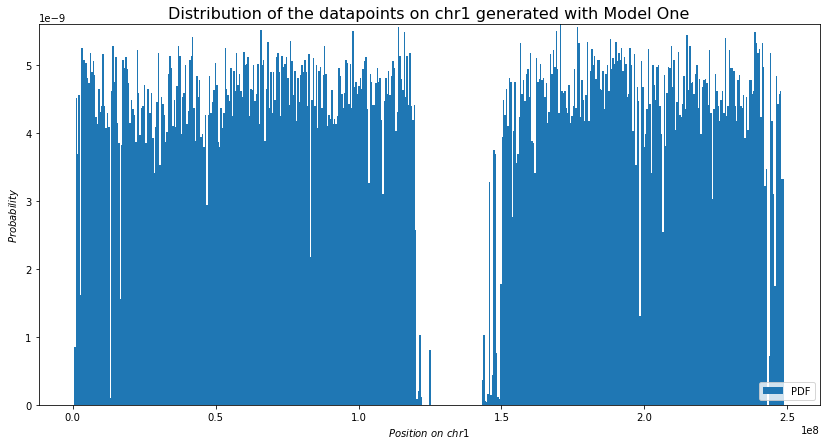

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.hist(positions,normed=True, label = 'PDF', bins = 500)
plt.xlabel("$Position\ on\ chr1$")
plt.ylabel("$Probability$")
plt.legend(loc='lower right')
plt.title("Distribution of the datapoints on chr1 generated with Model One", fontsize=16)
plt.savefig("../figures/ModelOne_100000IS_chr1.pdf")
plt.show()

If we compare this distribution with the one from model Zero below, it is clearly seen that in some regions there are no or much less positions generated. For instance, there is the centromere region that is clearly seen between 1e8 and 1.5e8. This corresponds exactly to what we expect.

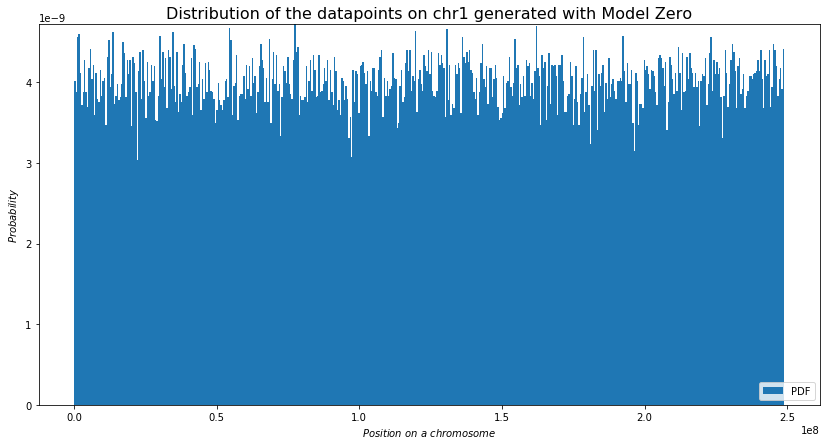

In [19]:
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
#the function has two arguments: n is a number of regions, chrom is a string containing a chromosome name
def plotDistribution(n,chrom):
    chrLen = dimension_dict[chrom]
    position = []
    for i in range(n):
        position.append(random.randint(1,chrLen))
    plt.figure(figsize=(14,7))
    plt.hist(position,normed=True, label = 'PDF',bins=500)
    plt.xlabel("$Position\ on\ a\ chromosome$")
    plt.ylabel("$Probability$")
    plt.legend(loc='lower right')
    plt.title("Distribution of the datapoints on chr1 generated with Model Zero", fontsize=16)
    plt.savefig("../figures/ModelZero_10000IS_chr1.pdf")
    plt.show()
plotDistribution(100000,'chr1')
    

Apply Kolmogorov-Smirnov test to compare two distributions

In [23]:
chrLen = dimension_dict["chr1"]
mzero = []
for i in range(100000):
    mzero.append(random.randint(1,chrLen))

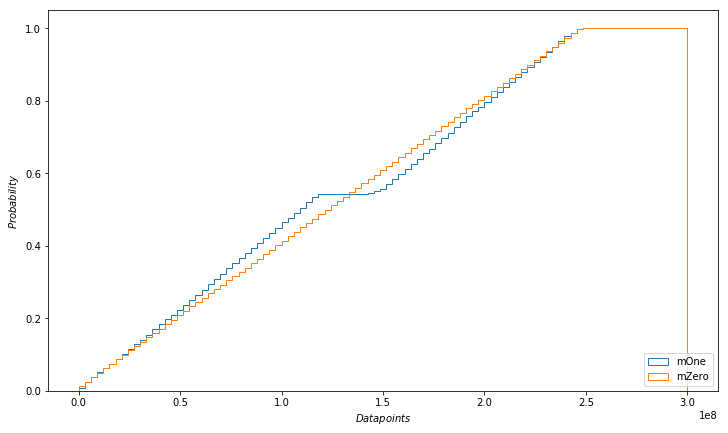

In [27]:
plt.figure(figsize=(12,7))
plt.hist(positions, normed=True, cumulative=True, histtype="step",label='mOne', bins=np.linspace(1,300000000,100))
plt.hist(mzero, normed=True, cumulative=True, histtype="step",label='mZero', bins=np.linspace(1,300000000,100))
plt.xlabel("$Datapoints$")
plt.ylabel("$Probability$")
plt.legend(loc='lower right')
plt.show()

In [28]:
from scipy.stats import ks_2samp
ks_2samp(positions, mzero)

Ks_2sampResult(statistic=0.061210000000000042, pvalue=2.5707966369979617e-163)

The P-value is very low, much less than the standard significance level of 5%, so Model One and Zero generate datasets from different distributions.

Make a textfile with 100000 IS on chr1 for future use in statistical tests:

In [3]:
from __future__ import print_function
with open('../testdata/map40_IS100000_chr1.txt', 'w') as f:
    print("Chromosome\tStart\tEnd\tMatch\tRnd Model\tAssembly", file=f)

In [7]:
import numpy as np
import pandas as pd
def getMappableIRSingleChr(inputf,chr_name,kmer,mapname,N,outputf):
    """Generate N positions on a respective chromosome using the map of choice"""
    with open(inputf,"r"):
        chr_arr = np.genfromtxt(inputf,dtype=None)
    counter = 1
    while counter<=N:
        rand_num = np.random.randint(1,dimension_dict[chr_name])
        matched_index = np.searchsorted(chr_arr["f0"],rand_num)-1
        if chr_arr["f1"][matched_index] == True:
            #append to the file that has been previously created with headers
            with open(outputf, 'a') as f:
                print (chr_name,"\t",rand_num,"\t",rand_num+1,"\t", "unmatched","\t",mapname,"\t", "hg38", file=f)                    
                counter+=1
        else:
            continue
            

In [8]:
getMappableIRSingleChr("../testdata/chr1_40_mappableshort.txt","chr1",kmer40, "map_40", 100000, '../testdata/map40_IS100000_chr1.txt')